# Deep GPs and DSPPs w/ Multiple Outputs

## Introduction

In this example, we will demonstrate how to construct deep GPs that can model vector-valued functions (e.g. multitask/multi-output GPs).

This tutorial can also be used to construct multitask [deep sigma point processes](./Deep_Sigma_Point_Processes.ipynb) by replacing `DeepGPLayer`/`DeepGP`/`DeepApproximateMLL` with `DSPPLayer`/`DSPP`/`DeepPredictiveLogLikelihood`.


In [1]:
import os
import torch
import tqdm
import math
import gpytorch
from torch.nn import Linear
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, \
    LMCVariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt

smoke_test = ('CI' in os.environ)
%matplotlib inline

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have four functions - all of which are some sort of sinusoid. Our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + 2 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

train_x = train_x.unsqueeze(-1)

## Structure of a multitask deep GP

The layers of a multitask deep GP will look identical to the layers of a [single-output deep GP](./Deep_Gaussian_Processes.ipynb).

In [3]:
# Here's a simple standard layer

class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, linear_mean=True):
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = ConstantMean() if linear_mean else LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

The main body of the deep GP will look very similar to the single-output deep GP, with a few changes.

**Most importantly** - the last layer will have `output_dims=num_tasks`, rather than `output_dims=None`. As a result, the output of the model will be a `MultitaskMultivariateNormal` rather than a standard `MultivariateNormal` distribution.

There are two other small changes, which are noted in the comments.

In [4]:
num_tasks = train_y.size(-1)
num_hidden_dgp_dims = 3


class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = DGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dgp_dims,
            linear_mean=True
        )
        last_layer = DGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=num_tasks,
            linear_mean=False
        )
        
        super().__init__()
        
        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        
        # We're going to use a ultitask likelihood instead of the standard GaussianLikelihood
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)
    
    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output
    
    def predict(self, test_x):
        with torch.no_grad():

            # The output of the model is a multitask MVN, where both the data points
            # and the tasks are jointly distributed
            # To compute the marginal predictive NLL of each data point,
            # we will call `to_data_independent_dist`,
            # which removes the data cross-covariance terms from the distribution.
            preds = model.likelihood(model(test_x)).to_data_independent_dist()
            
        return preds.mean.mean(0), preds.variance.mean(0)


model = MultitaskDeepGP(train_x.shape)

### Training and making predictions

This code should look similar to the DGP training code.

In [5]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data=train_y.size(0)))

num_epochs = 1 if smoke_test else 200
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

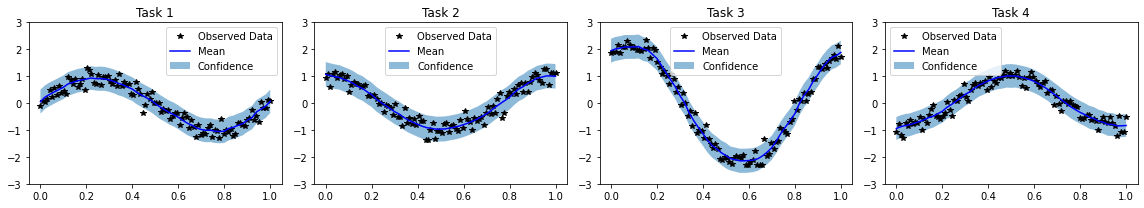

In [6]:

# Make predictions
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51).unsqueeze(-1)
    mean, var = model.predict(test_x)
    lower = mean - 2 * var.sqrt()
    upper = mean + 2 * var.sqrt()

# Plot results
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))
for task, ax in enumerate(axs):
    ax.plot(train_x.squeeze(-1).detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    ax.plot(test_x.squeeze(-1).numpy(), mean[:, task].numpy(), 'b')
    ax.fill_between(test_x.squeeze(-1).numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')
fig.tight_layout()
None